<a href="https://colab.research.google.com/github/peteray-dev/Skin-Lesion-Clf-Det/blob/master/Skin_Cancer_Classification_dect__Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EARLY SKIN CANCER DETECTION - CNN


The objectives of this work is to

* Solve image classifcation of skin diseases that can result into cancer if not detected early and treated, the classification is done using convolutaional neural networks (CNNs) - customized CNN layers, Pretrained CNN ( VGG-19, Resnet18)


# 1 Import Packages

First, all packages are imported

In this work, I'm relying on **torchvision**, a library of PyTorch.

In [ ]:
pip install torch-lr-finder -q

In [ ]:
pip install Augmentor -q

In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# learning rate
from torch_lr_finder import LRFinder

# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 The ISIC skin cancer classification Dataset

The dataset used is collected by ISIC [Skin cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data') on Kaggle

The dataset includes 9 classes of skin diseases that can result into skin cancer, the classes include: Actinic Keratosis, basal cell carcinoma, dermatofibroma, melanoma, nevus, pigmented benign keratosis, squamous cell carcinoma, vascular lesion



In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data') # access the dataset using kaggle details

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: peteray
Your Kaggle Key: ··········


100%|██████████| 786M/786M [00:09<00:00, 84.5MB/s]


## 2.2 PyTorch Dataset and Dataloader

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.ImageFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
# It is important to do data augmentation in training.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),# Adjust color
    transforms.CenterCrop(250),
    # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 1), ratio(0.5,2)),



    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train",
                                     transform=train_transform)
test_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
                                    transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.85
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 2239 samples
Train set has 1903 samples
Validation set has 336 samples
Test set has 118 samples


In [ ]:
# Balancing of the 9 classes
import Augmentor
import os
import pathlib

# Define the path to the training dataset
path_to_training_dataset = pathlib.Path(r'/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
output_directory = os.getcwd() + '/Augment Train Data/'

class_names = train_dataset.classes


# Convert class_names to a list if it's not already
class_names = list(class_names)

# Iterate through each class and create Augmentor pipeline
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i), output_directory=str(output_directory + i + '/output/'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/Augment Train Data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4C8C41B850>: 100%|██████████| 500/500 [00:16<00:00, 30.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Augment Train Data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D4C8C4B2E30>: 100%|██████████| 500/500 [00:18<00:00, 27.47 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Augment Train Data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4C8C3FC910>: 100%|██████████| 500/500 [00:19<00:00, 25.20 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Augment Train Data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D4C8C4707F0>: 100%|██████████| 500/500 [01:19<00:00,  6.31 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Augment Train Data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D4C8E5CF8E0>: 100%|██████████| 500/500 [01:03<00:00,  7.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Augment Train Data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4C8E888460>: 100%|██████████| 500/500 [00:14<00:00, 35.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Augment Train Data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D4C94F6F6A0>: 100%|██████████| 500/500 [00:35<00:00, 14.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Augment Train Data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4C8E5CF5E0>: 100%|██████████| 500/500 [00:14<00:00, 35.14 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Augment Train Data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4D87FEE950>: 100%|██████████| 500/500 [00:13<00:00, 35.86 Samples/s]


In [ ]:
output_dir = pathlib.Path(output_directory)  # Convert output directory to a Path object
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
import os
output_directory = os.getcwd() + '/augmented_images/'

In [ ]:
train_dataset = datasets.ImageFolder("/content/Augment Train Data",
                                     transform=train_transform)
test_dataset = datasets.ImageFolder("/content/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
                                    transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.85
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 4500 samples
Train set has 3825 samples
Validation set has 675 samples
Test set has 118 samples


In [ ]:
# Get labels for train, validation, and test sets
train_labels = [train_subset[i][1] for i in range(len(train_subset))]
val_labels = [val_subset[i][1] for i in range(len(val_subset))]  # Extract labels from val_subset
test_labels = test_dataset.targets

# Compute counts for unique labels in each dataset
train_unique_values, train_counts = np.unique(train_labels, return_counts=True)
val_unique_values, val_counts = np.unique(val_labels, return_counts=True)
test_unique_values, test_counts = np.unique(test_labels, return_counts=True)

In [ ]:
pd.DataFrame({'train': train_counts, 'val': val_counts,
                      'test': test_counts },
                      index=class_names)

train  val  test
actinic keratosis             416   84    16
basal cell carcinoma          423   77    16
dermatofibroma                426   74    16
melanoma                      430   70    16
nevus                         423   77    16
pigmented benign keratosis    427   73    16
seborrheic keratosis          437   63     3
squamous cell carcinoma       431   69    16
vascular lesion               412   88     3

In [ ]:

sk_data = pd.DataFrame({'train': train_counts,
                        'val': val_counts,
                      'test': test_counts},
                      index=class_names
)

<Figure size 1000x600 with 0 Axes>

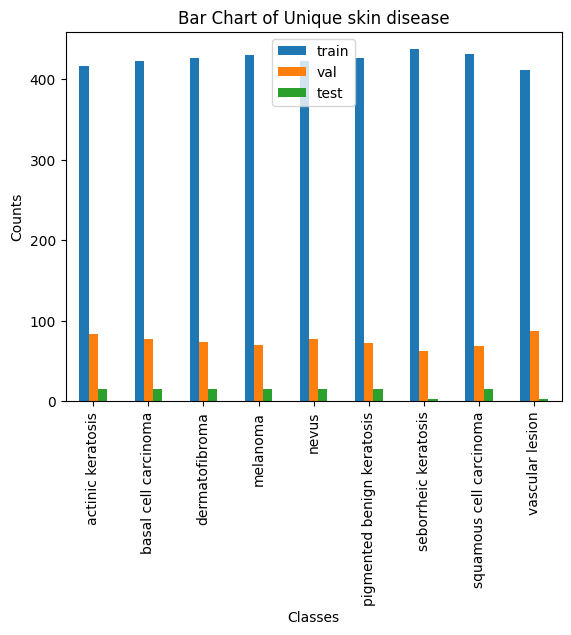

In [ ]:

plt.figure(figsize=(10, 6))
sk_data.plot(kind='bar')

plt.xticks(rotation=90)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Bar Chart of Unique skin disease');

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32 #32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

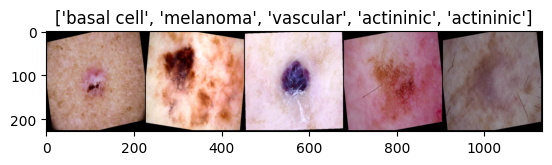

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['actininic', 'basal cell', 'dermatofibroma', 'melanoma', 'nevus',
               'benign', 'seborrheic', 'squamous', 'vascular']

imshow(out, title=[class_names[x] for x in classes])

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


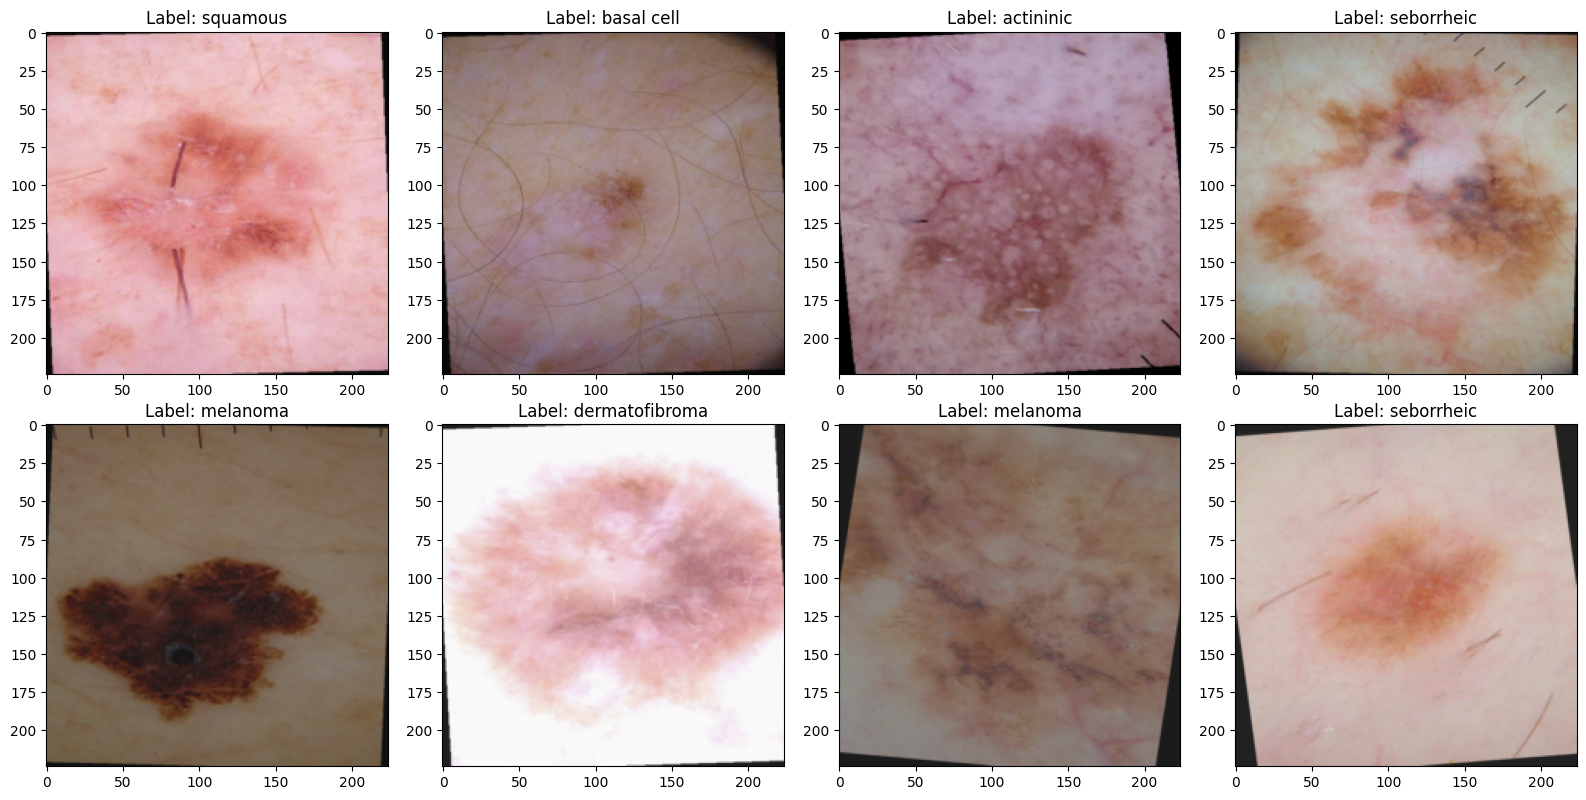

In [ ]:
# import matplotlib.pyplot as plt
# import torch

# Display images and labels.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_names = ['actininic', 'basal cell', 'dermatofibroma', 'melanoma', 'nevus',
               'benign', 'seborrheic', 'squamous', 'vascular']

# Create a subplot grid with 2 rows and 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        # Transpose dimensions from (3, 224, 224) to (224, 224, 3)
        img = torch.transpose(train_features[i*4+j], 0, 2).numpy()
        label = train_labels[i*4+j]
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Label: {label_names[label]}")

plt.tight_layout()
plt.show()


# 3 Model

The basic model here is simply a stack of **convolutional layers** followed by some **fully-connected layers**.

Since there are three channels for a color image (RGB), the **input channels** of the network must be **three**.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the **feature map must be flattened into a single one-dimensional vector** (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.



In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0

            # nn.Conv2d(256, 512, 3, 1, 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 9),

        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
GPU Device Name: Tesla T4


In [ ]:

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Linear-13                  [-1, 256]      12,845,312
             ReLU-14                  [

# 4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-05


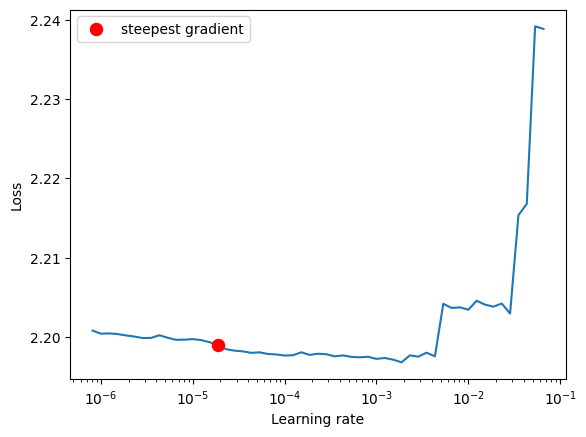

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

# Reference: https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.LearningRateFinder.html

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

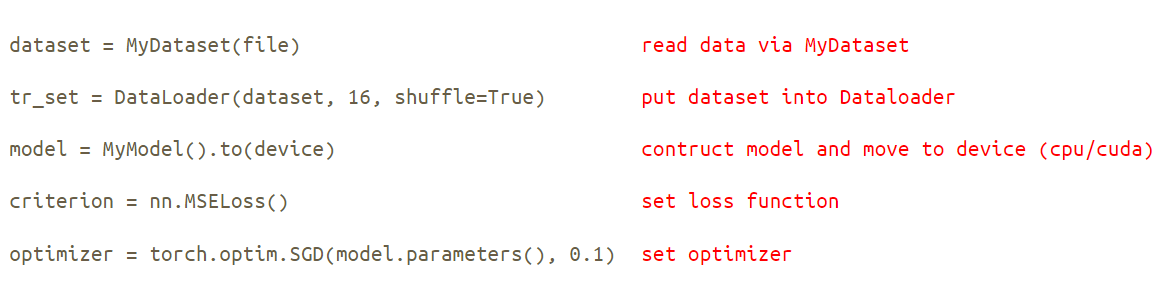

# 5 Train and Validation

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.5)
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)



    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')


    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 001/050] Train: loss=2.18878, acc=0.12829 | Valid: loss=2.06980, acc=0.25805


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 002/050] Train: loss=1.82753, acc=0.28575 | Valid: loss=1.69765, acc=0.31487


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 003/050] Train: loss=1.66457, acc=0.34799 | Valid: loss=1.53197, acc=0.38968


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 004/050] Train: loss=1.58123, acc=0.38051 | Valid: loss=1.48614, acc=0.42235


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 005/050] Train: loss=1.56239, acc=0.38471 | Valid: loss=1.48759, acc=0.41004


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 006/050] Train: loss=1.52909, acc=0.39432 | Valid: loss=1.52195, acc=0.39631


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 007/050] Train: loss=1.52819, acc=0.39887 | Valid: loss=1.48966, acc=0.40294


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 008/050] Train: loss=1.51088, acc=0.41518 | Valid: loss=1.42207, acc=0.44176


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 009/050] Train: loss=1.50320, acc=0.41512 | Valid: loss=1.44226, acc=0.41335


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 010/050] Train: loss=1.47224, acc=0.42316 | Valid: loss=1.37879, acc=0.46922


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 011/050] Train: loss=1.42331, acc=0.44487 | Valid: loss=1.39738, acc=0.45407


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 012/050] Train: loss=1.42016, acc=0.44350 | Valid: loss=1.39417, acc=0.42140


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 013/050] Train: loss=1.42042, acc=0.45040 | Valid: loss=1.46433, acc=0.40909


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 014/050] Train: loss=1.35684, acc=0.47537 | Valid: loss=1.40125, acc=0.43277


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 015/050] Train: loss=1.33357, acc=0.47748 | Valid: loss=1.41886, acc=0.44129


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 016/050] Train: loss=1.29807, acc=0.50806 | Valid: loss=1.34154, acc=0.47775


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 017/050] Train: loss=1.25774, acc=0.52235 | Valid: loss=1.32686, acc=0.48390


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 018/050] Train: loss=1.23094, acc=0.52010 | Valid: loss=1.24937, acc=0.53030


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 019/050] Train: loss=1.20492, acc=0.53123 | Valid: loss=1.17836, acc=0.54403


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 020/050] Train: loss=1.17183, acc=0.55438 | Valid: loss=1.27173, acc=0.50900


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 021/050] Train: loss=1.15044, acc=0.54735 | Valid: loss=1.19250, acc=0.55019


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 022/050] Train: loss=1.13140, acc=0.56463 | Valid: loss=1.19285, acc=0.54167


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 023/050] Train: loss=1.12007, acc=0.56376 | Valid: loss=1.19162, acc=0.54593


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 024/050] Train: loss=1.07261, acc=0.58589 | Valid: loss=1.16780, acc=0.54498


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 025/050] Train: loss=1.05401, acc=0.60233 | Valid: loss=1.09458, acc=0.60417


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 026/050] Train: loss=1.04405, acc=0.60080 | Valid: loss=1.26022, acc=0.52367


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 027/050] Train: loss=1.02409, acc=0.61236 | Valid: loss=1.15633, acc=0.54640


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 028/050] Train: loss=0.98145, acc=0.63485 | Valid: loss=1.13267, acc=0.57907


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 029/050] Train: loss=0.94353, acc=0.63879 | Valid: loss=1.03839, acc=0.60511


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 030/050] Train: loss=0.92239, acc=0.65484 | Valid: loss=1.12079, acc=0.57055


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 031/050] Train: loss=0.93511, acc=0.64631 | Valid: loss=1.13497, acc=0.55492


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 032/050] Train: loss=0.88995, acc=0.66057 | Valid: loss=1.12130, acc=0.58996


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 033/050] Train: loss=0.89090, acc=0.66809 | Valid: loss=1.05853, acc=0.61979


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 034/050] Train: loss=0.84709, acc=0.68632 | Valid: loss=1.04297, acc=0.61695


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 035/050] Train: loss=0.84057, acc=0.66913 | Valid: loss=1.01631, acc=0.62169


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 036/050] Train: loss=0.80651, acc=0.69862 | Valid: loss=1.01352, acc=0.62737


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 037/050] Train: loss=0.80789, acc=0.69436 | Valid: loss=1.03067, acc=0.66525


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 038/050] Train: loss=0.77260, acc=0.70959 | Valid: loss=0.99071, acc=0.61600


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 039/050] Train: loss=0.73778, acc=0.72701 | Valid: loss=1.00088, acc=0.64394


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 040/050] Train: loss=0.73736, acc=0.72698 | Valid: loss=1.01128, acc=0.64962


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 041/050] Train: loss=0.73391, acc=0.72515 | Valid: loss=0.99072, acc=0.64394


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 042/050] Train: loss=0.68531, acc=0.75400 | Valid: loss=1.01589, acc=0.64394


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 043/050] Train: loss=0.69422, acc=0.74940 | Valid: loss=0.97332, acc=0.67093


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 044/050] Train: loss=0.67461, acc=0.74862 | Valid: loss=0.90072, acc=0.69034


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 045/050] Train: loss=0.65600, acc=0.75093 | Valid: loss=0.94949, acc=0.67377


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 046/050] Train: loss=0.65231, acc=0.75576 | Valid: loss=0.93747, acc=0.67661


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 047/050] Train: loss=0.62108, acc=0.77515 | Valid: loss=0.96553, acc=0.67093


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 048/050] Train: loss=0.62540, acc=0.77877 | Valid: loss=0.93798, acc=0.67945


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 049/050] Train: loss=0.57112, acc=0.78583 | Valid: loss=0.91617, acc=0.68655


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 050/050] Train: loss=0.57836, acc=0.78502 | Valid: loss=1.09857, acc=0.65862


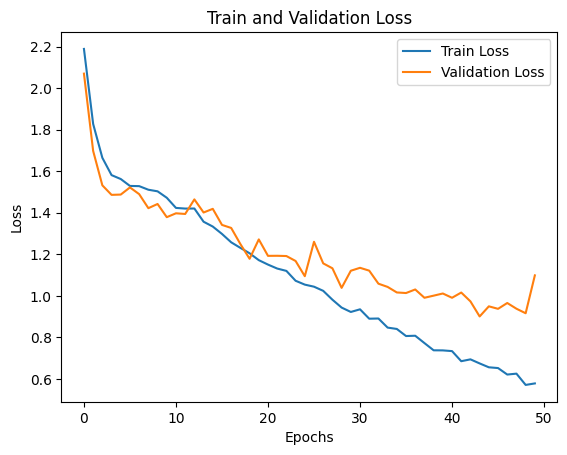

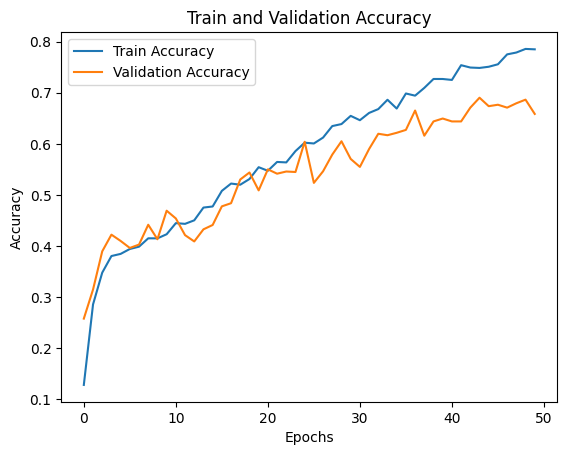

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# 6 Testing




Before making test, please make sure you have selected the best model parameters through best validation accuracy.

Idealy, you should only run the following code once in your entire deep learning model development pipeline.

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy 0.35298293828964233


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.25      0.27        16
           1       0.38      0.31      0.34        16
           2       0.50      0.25      0.33        16
           3       0.12      0.06      0.08        16
           4       0.39      1.00      0.56        16
           5       0.42      0.31      0.36        16
           6       0.00      0.00      0.00         3
           7       0.28      0.31      0.29        16
           8       0.50      0.67      0.57         3

    accuracy                           0.36       118
   macro avg       0.32      0.35      0.31       118
weighted avg       0.34      0.36      0.32       118



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'actinic keratosis'),
  Text(1, 0, 'basal cell carcinoma'),
  Text(2, 0, 'dermatofibroma'),
  Text(3, 0, 'melanoma'),
  Text(4, 0, 'nevus'),
  Text(5, 0, 'pigmented benign keratosis'),
  Text(6, 0, 'seborrheic keratosis'),
  Text(7, 0, 'squamous cell carcinoma'),
  Text(8, 0, 'vascular lesion')])

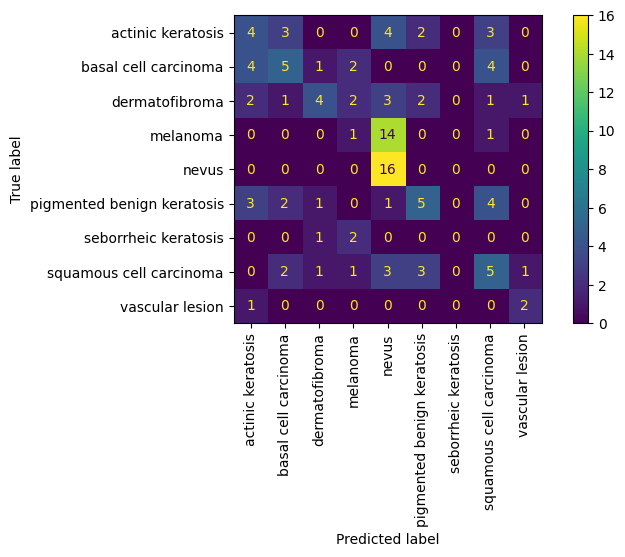

In [ ]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)

In [ ]:
from sklearn.metrics import accuracy_score

# Compute the test accuracy using y_test and y_pred
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.3559322033898305


# 7 Improve Performance

## 7.1 Data Augmentation

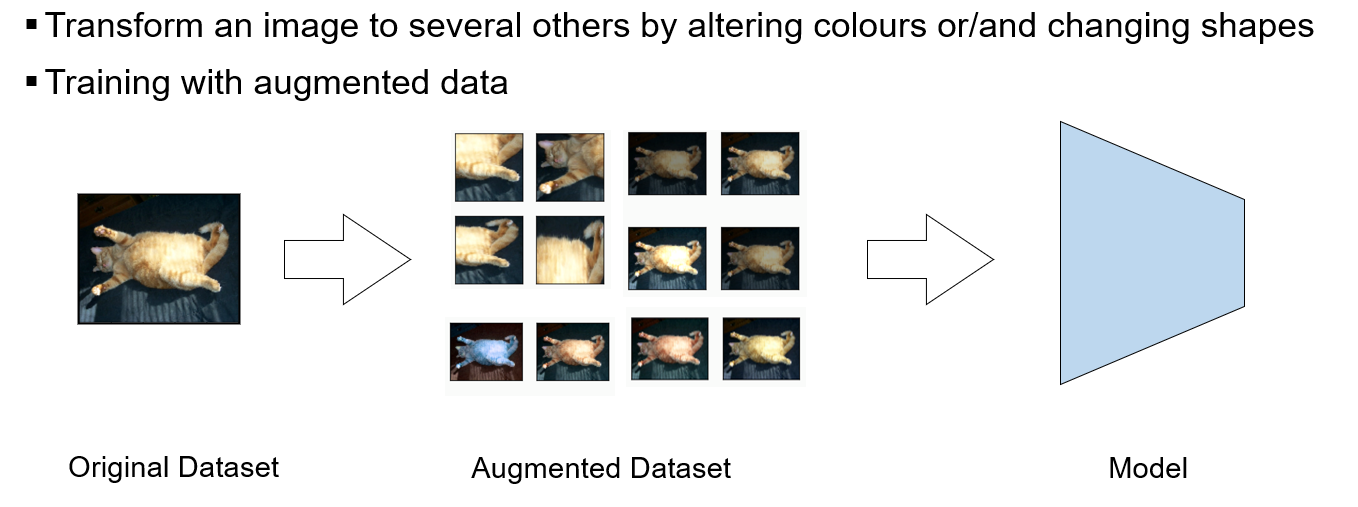

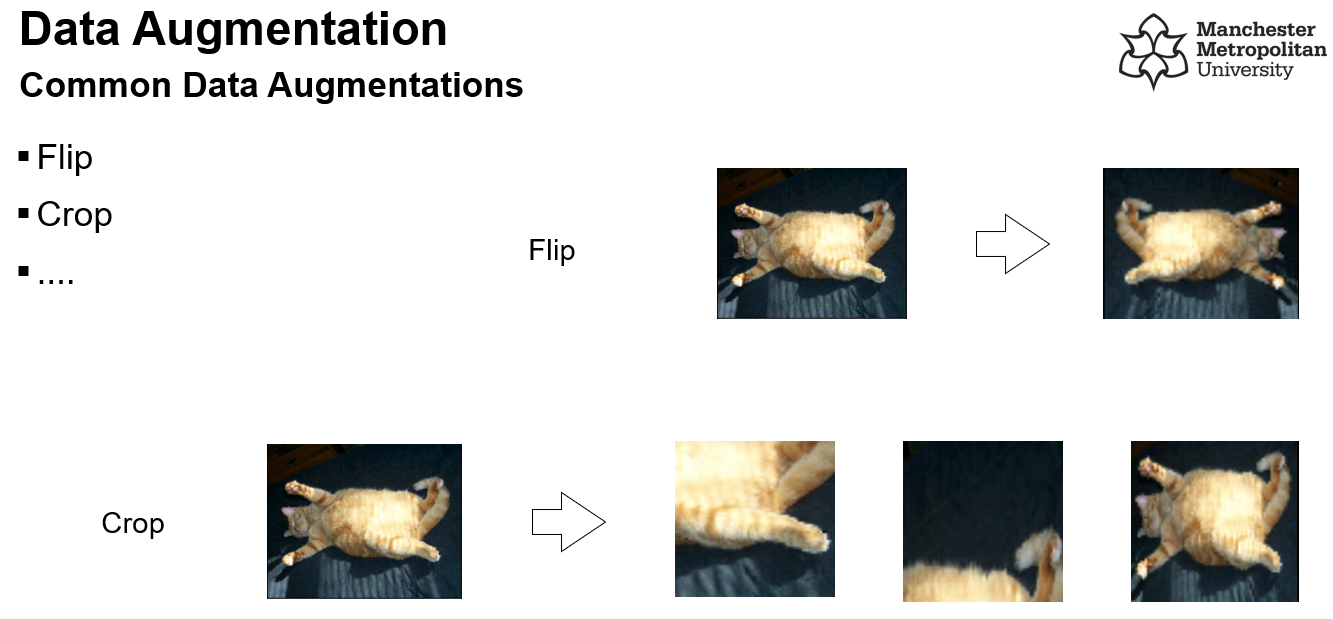

You can use the following part of the code to replace the orginal transformation to apply data augmentation to see if there is an improvement.

```
import torchvision.transforms as transforms

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Adjust color
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
```



## 7.2 Use Pretrained Model and Weights


For example, if you use ResNet-18 as your model:

`model = torchvision.models.resnet18(num_classes=7)`

There are more models in [torchvision.models](https://pytorch.org/vision/stable/models.html). You can access AlexNet, DenseNet, GooLeNet, InceptionNet, MobileNet, etc.

You can also load model parameters trained on ImageNet, but you have to manually modify the output number of classes.

`model = torchvision.models.resnet18(pretrained=True)  `


# 8 Hot to use this code for my own project (dataset)?

[Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file annotations_file.



```
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
```

`__init__`

The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```
```
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

`__len__`

The `__len__` function returns the number of samples in our dataset.

Example:
```
def __len__(self):
    return len(self.img_labels)
```

`__getitem__`

The `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
```
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label
```

More about loading your own datasets:

[Developing Custom PyTorch Dataloaders](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

[Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

[Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


# Ackowledgement

This lab is modified by Xinqi Fan for Deep Learning at Manchester Metropolitan University.

The original jupyter notebook was developed for the Machine Learning course offered by Prof. Hung-yi Lee from Department of Electrical Engineering, National Taiwan University.

Using a pretrained CNN model VGG (Transfer Learning)-Fine Tuning

# ResNet18



In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc.out_features = 9
print(model)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=1.0)
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model_res.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=2.06818, acc=0.52912 | Valid: loss=0.91360, acc=0.66903


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=0.70575, acc=0.74023 | Valid: loss=0.64213, acc=0.76562


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.48506, acc=0.81881 | Valid: loss=0.55407, acc=0.80540


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.42249, acc=0.84622 | Valid: loss=0.73663, acc=0.76562


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.33949, acc=0.88320 | Valid: loss=0.57030, acc=0.79593


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.29122, acc=0.89459 | Valid: loss=0.49914, acc=0.83097


  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

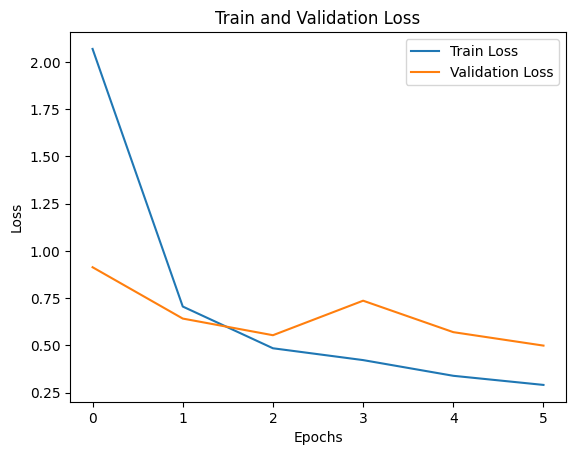

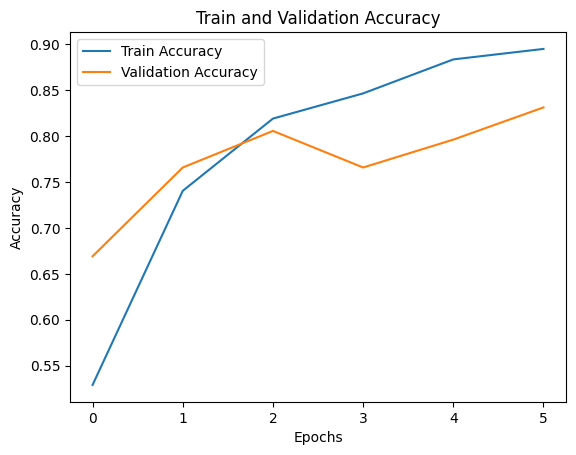

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model_res.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy 0.5085227489471436


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.69      0.56      0.62        16
           2       0.85      0.69      0.76        16
           3       0.00      0.00      0.00        16
           4       0.38      1.00      0.55        16
           5       0.67      0.50      0.57        16
           6       0.00      0.00      0.00         3
           7       0.35      0.38      0.36        16
           8       1.00      1.00      1.00         3

    accuracy                           0.52       118
   macro avg       0.54      0.51      0.50       118
weighted avg       0.54      0.52      0.50       118



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'actinic keratosis'),
  Text(1, 0, 'basal cell carcinoma'),
  Text(2, 0, 'dermatofibroma'),
  Text(3, 0, 'melanoma'),
  Text(4, 0, 'nevus'),
  Text(5, 0, 'pigmented benign keratosis'),
  Text(6, 0, 'seborrheic keratosis'),
  Text(7, 0, 'squamous cell carcinoma'),
  Text(8, 0, 'vascular lesion')])

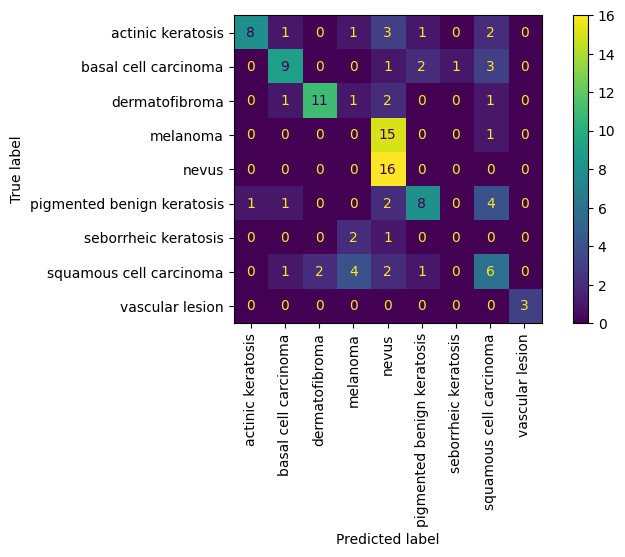

In [ ]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)


# VGG16




In [ ]:
model = torchvision.models.vgg16(weights= 'imagenet', num_classes =9)

print(model)
model = model.to(device)

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1.42E-04)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=1.0)
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model_res.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model_res.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()
y_test=[]
y_pred = []

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

In [ ]:

class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)

# Inception_V3


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

# model = torchvision.models.inception_v3()

# Lets freeze all layers and change just a few layers to match our requirements

def get_model():
    model = torchvision.models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,9))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
model, loss_fn, optimizer = get_model()


In [ ]:
from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)

In [ ]:
#Creating the Utlity function to get the Losses and Accuracies for Train and Validation Dataset

def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
model, loss_fn, optimizer = get_model()


In [ ]:
# Start the Model Training and save the Losses and Accuracies of Both train and validation

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(40):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_loader)):
#         print(f"ix - {ix}, {batch}")
        x, y = batch
#         print(f"type of x - {type(x)}, type of y - {type(y)}")
        x, y= x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print('Epoch:',epoch,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)

    for ix, batch in enumerate(iter(validation_data)):
        x, y = batch
        x, y= x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        val_epoch_accuracy = np.mean(val_is_correct)

    print('Epoch:',epoch,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.90)
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)



    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')


    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

In [ ]:

# Load Inception_v3 model
model = torchvision.models.inception_v3(pretrained=True)

# Modify the final fully connected layer for your task
num_classes = 9
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 180),
    nn.ReLU(inplace=True),  # Example activation function
    nn.Linear(180, num_classes)
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Assuming you have your input data and labels
inputs = torch.randn(4, 3, 299, 299).to(device)  # Example input tensor
labels = torch.randint(0, num_classes, (4,)).to(device)  # Example labels tensor

# Forward pass
outputs = model(inputs)

# Apply softmax activation to convert outputs to probabilities
softmax_outputs = nn.functional.softmax(outputs, dim=1)

# Compute the cross-entropy loss
loss = criterion(softmax_outputs, labels)

# Now you can use the loss for backpropagation and optimization


In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.32E-03)

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.90)
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)



    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')


    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model_vgg.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)


    predictions = logits.argmax(dim=-1)

    y_test.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

report = classification_report(y_test, y_pred)
print(report)

In [ ]:


class_names = train_dataset.classes

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 4))
display.plot(ax=ax);


plt.xticks(rotation=90)